# MNIST Digit Classification - Fully Connected Network

In [1]:
from __future__ import division, print_function
from keras.models import Sequential, load_model
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras.layers.core import Dense, Dropout
from keras.utils import np_utils
from sklearn.metrics import accuracy_score, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import os
%matplotlib inline

Using TensorFlow backend.


In [2]:
DATA_DIR = "../../data"
TRAIN_FILE = os.path.join(DATA_DIR, "mnist_train.csv")
TEST_FILE = os.path.join(DATA_DIR, "mnist_test.csv")

BEST_MODEL = os.path.join(DATA_DIR, "keras-mnist-fcn-best.h5")
FINAL_MODEL = os.path.join(DATA_DIR, "keras-mnist-fcn-final.h5")
TENSORBOARD_LOGS_DIR = os.path.join(DATA_DIR, "keras-mnist-fcn-tensorboard")

BATCH_SIZE = 128
NUM_CLASSES = 10
NUM_EPOCHS = 10

## Prepare Data

In [3]:
def parse_file(filename):
    xdata, ydata = [], []
    fin = open(filename, "rb")
    i = 0
    for line in fin:
        if i % 10000 == 0:
            print("{:s}: {:d} lines read".format(
                os.path.basename(filename), i))
        cols = line.strip().split(",")
        ydata.append(int(cols[0]))
        xdata.append([float(x) / 255. for x in cols[1:]])
        i += 1
    fin.close()
    print("{:s}: {:d} lines read".format(os.path.basename(filename), i))
    Y = np_utils.to_categorical(np.array(ydata), num_classes=NUM_CLASSES)
    X = np.array(xdata)
    return X, Y

Xtrain, Ytrain = parse_file(TRAIN_FILE)
Xtest, Ytest = parse_file(TEST_FILE)
print(Xtrain.shape, Ytrain.shape, Xtest.shape, Ytest.shape)

mnist_train.csv: 0 lines read
mnist_train.csv: 10000 lines read
mnist_train.csv: 20000 lines read
mnist_train.csv: 30000 lines read
mnist_train.csv: 40000 lines read
mnist_train.csv: 50000 lines read
mnist_train.csv: 60000 lines read
mnist_test.csv: 0 lines read
mnist_test.csv: 10000 lines read
(60000, 784) (60000, 10) (10000, 784) (10000, 10)


## Define Network

Model is identical to that defined in Keras example [mnist_mlp.py](https://github.com/fchollet/keras/blob/master/examples/mnist_mlp.py).

In [4]:
model = Sequential()
model.add(Dense(512, activation="relu", input_shape=(784,)))
model.add(Dropout(0.2))
model.add(Dense(256, activation="relu"))
model.add(Dropout(0.2))
model.add(Dense(10, activation="softmax"))

In [5]:
model.compile(optimizer="adam", loss="categorical_crossentropy", 
              metrics=["accuracy"])

In [6]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 512)               401920    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 10)                2570      
Total params: 535,818
Trainable params: 535,818
Non-trainable params: 0
_________________________________________________________________


## Train Network

The Tensorboard callback, if enabled will write out the training logs to the directory given by TENSORBOARD_LOGS_DIR, and you can now start the tensorboard server using the following command:

    tensorboard --logdir=/path/to/TENSORBOARD_LOGS_DIR
    
The tensorboard application can be accessed from the browser at http://localhost:6060

In [7]:
checkpoint = ModelCheckpoint(filepath=BEST_MODEL, save_best_only=True)
tensorboard = TensorBoard(log_dir=TENSORBOARD_LOGS_DIR, 
                          histogram_freq=1, 
                          batch_size=BATCH_SIZE, 
                          write_graph=True, 
                          write_grads=True, 
                          write_images=False, 
                          embeddings_freq=0, 
                          embeddings_layer_names=None, 
                          embeddings_metadata=None)
history = model.fit(Xtrain, Ytrain, batch_size=BATCH_SIZE, 
                    epochs=NUM_EPOCHS,
                    validation_split=0.1,
                    callbacks=[checkpoint, tensorboard])

Train on 54000 samples, validate on 6000 samples
Epoch 1/10
54000/54000 [==============================] - 6s - loss: 0.2826 - acc: 0.9153 - val_loss: 0.1008 - val_acc: 0.9700
Epoch 2/10
54000/54000 [==============================] - 5s - loss: 0.1128 - acc: 0.9659 - val_loss: 0.0739 - val_acc: 0.9778
Epoch 3/10
54000/54000 [==============================] - 5s - loss: 0.0796 - acc: 0.9741 - val_loss: 0.0757 - val_acc: 0.9777
Epoch 4/10
54000/54000 [==============================] - 5s - loss: 0.0614 - acc: 0.9802 - val_loss: 0.0715 - val_acc: 0.9800
Epoch 5/10
54000/54000 [==============================] - 5s - loss: 0.0505 - acc: 0.9836 - val_loss: 0.0616 - val_acc: 0.9832
Epoch 6/10
54000/54000 [==============================] - 5s - loss: 0.0432 - acc: 0.9856 - val_loss: 0.0622 - val_acc: 0.9822
Epoch 7/10
54000/54000 [==============================] - 5s - loss: 0.0344 - acc: 0.9883 - val_loss: 0.0710 - val_acc: 0.9793
Epoch 8/10
54000/54000 [==============================] - 5s -

In [8]:
model.save(FINAL_MODEL, overwrite=True)

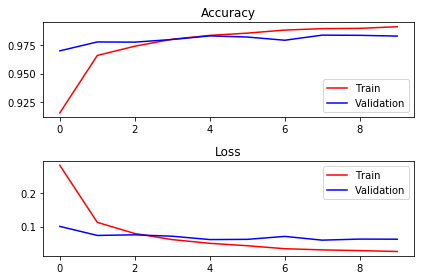

In [9]:
plt.subplot(211)
plt.title("Accuracy")
plt.plot(history.history["acc"], color="r", label="Train")
plt.plot(history.history["val_acc"], color="b", label="Validation")
plt.legend(loc="best")

plt.subplot(212)
plt.title("Loss")
plt.plot(history.history["loss"], color="r", label="Train")
plt.plot(history.history["val_loss"], color="b", label="Validation")
plt.legend(loc="best")

plt.tight_layout()
plt.show()

## Evaluate Network

In [10]:
def evaluate_model(model, model_name):
    print("==== eval {:s} model on test set ====".format(model_name))
    Ytest_ = model.predict(Xtest)
    ytest = np.argmax(Ytest, axis=1)
    ytest_ = np.argmax(Ytest_, axis=1)
    acc = accuracy_score(ytest, ytest_)
    cm = confusion_matrix(ytest, ytest_)
    print("Accuracy: {:.4f}".format(acc))
    print("Confusion Matrix")
    print(cm)

evaluate_model(model, "best")

model = load_model(BEST_MODEL)
evaluate_model(model, "final")

==== eval best model on test set ====
Accuracy: 0.9805
Confusion Matrix
[[ 971    1    1    2    0    1    1    0    2    1]
 [   0 1124    2    2    0    2    1    1    3    0]
 [   3    0 1009    5    4    1    1    3    5    1]
 [   0    0    2 1002    0    3    0    1    1    1]
 [   1    0    3    0  966    0    4    1    0    7]
 [   1    0    0    9    1  876    1    0    2    2]
 [   3    3    0    1    4   14  927    0    6    0]
 [   0    1    8    4    2    1    0 1002    4    6]
 [   0    1    1   12    2    3    1    2  947    5]
 [   1    2    0   11    7    3    1    2    1  981]]
==== eval final model on test set ====
Accuracy: 0.9821
Confusion Matrix
[[ 970    1    2    2    2    0    2    0    1    0]
 [   0 1130    2    0    0    1    0    0    2    0]
 [   1    1 1016    3    1    0    1    5    4    0]
 [   0    0    3  991    0    4    0    7    3    2]
 [   1    0    3    0  966    0    3    1    2    6]
 [   2    0    0   15    1  868    3    0    2    1]
 [   2